# XP Reader for PB2
### This XP reader allows to visualize the training results in pb2. 

### It works as follows
1. Locate the XP files on your computer
2. Parse the train.log and params.pkl files
3. Select experiments to be shown and display results
4. Print training curves

## 1. Locate the XP files on your computer


In [14]:

import os
from copy import deepcopy
import pickle
import matplotlib.pyplot as plt
import glob
import ast
import re
from datetime import datetime
from tabulate import tabulate
import numpy as np

#import tikzplotlib
from IPython.core.display import HTML

display(HTML("<style>.container {width:90% !important;}</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
from operator import itemgetter

"""
This file assumes that the results are stored in <path> as follows:
a folder with name xp_env contains subfolders each named with a corresponding xp_id and contain: 
- a file train.log
- a file params.pkl
"""


path = "/Users/hayat/downloads/" # Your dump path for XP
xp_env = ['train_pb2_sidon'] # Your name of environement, typically the name of the job 
has_beam=False

xp_id_filter=[] # Excluding specific experiments
xp_id_selector=[] # Selecting specific experiments
unwanted_args = ['dump_path'] # parameters that we do not want to store




# global variables
var_args = set()
all_args = {}


# list experiments
xps = [(env, xp) for env in xp_env for xp in os.listdir(path+'/'+env) if (len(xp_id_selector)==0 or xp in xp_id_selector) and (len(xp_id_filter)==0 or not xp in xp_id_filter)]
names = [path + env + '/' + xp for (env, xp) in xps]
print(len(names),"experiments found")

# read all args from the file params.pkl
pickled_xp = 0
for name in names:
    pa = name+'/params.pkl'
    if not os.path.exists(pa):
        print("Unpickled experiment: ", name)
        continue
    pk = pickle.load(open(pa,'rb'))
    all_args.update(pk.__dict__)
    pickled_xp += 1
print(pickled_xp, "pickled experiments found")
print()

# find variable args
for name in names:
    pa = name+'/params.pkl'
    if not os.path.exists(pa):
        continue
    pk = pickle.load(open(pa,'rb'))
    for key,value in all_args.items():
        if key in pk.__dict__ and value == pk.__dict__[key]:
            continue
        if key not in unwanted_args:
            var_args.add(key)

print("common args")
for key in all_args:
    if key not in unwanted_args and key not in var_args:
        print(key,"=", all_args[key])
print()
            
print(len(var_args)," variables params out of", len(all_args))
print(var_args)
          

105 experiments found
Unpickled experiment:  /Users/hayat/downloads/train_pb2_sidon/.DS_Store
104 pickled experiments found

common args
max_len = 500
M = 1
hard = True
insert_prob = 0.33
delete_prob = 0.33
shift_prob = 0.33
temp0 = 0.33
temp_decay = 0.33
init_method = random_greedy
init_k = -1
jitter_init = True
input_file = 
process_pool = True
seed = -1
top_k = -1
n_layer = 4
batch_size = 32
learning_rate = 0.0005
weight_decay = 0.01
gen_batch_size = 1000
exp_name = train_pb2_sidon
local_rank = 0
master_port = -1
cpu = False
debug_slurm = False
debug = False
is_slurm_job = True
n_nodes = 1
node_id = 0
global_rank = 0
world_size = 1
n_gpu_per_node = 1
is_master = True
multi_node = False
multi_gpu = False

46  variables params out of 82
{'max_output_length', 'sample_only', 'base', 'scoring_exp_score', 'triangle_hard', 'new_proportion', 'nosep', 'max_epochs', 'exp_id', 'random_greedy_search', 'device', 'reverse', 'master_addr', 'triangle_init_method', 'nb_ap', 'redeem', 'env_name', 'sy

## 2. Parse the train.log and params.pkl files


In [15]:

def vars_from_env_xp(env, xp):
    res = {}
    pa = path+env+'/'+xp+'/params.pkl'
    if not os.path.exists(pa):
        print("pickle", pa, "not found")
        return res
    pk = pickle.load(open(pa,'rb'))
    for key in var_args:
        if key in pk.__dict__: 
            res[key] = pk.__dict__[key]
        else:
            res[key] = None
    return res

def get_start_time(line):
    parsed_line = line.split(" ")
    dt = datetime.strptime(parsed_line[2]+' '+parsed_line[3],"%m/%d/%y %H:%M:%S")
    try:
        idx = parsed_line.index("epoch")
        curr_epoch = int(parsed_line[idx+1])
    except ValueError:
        curr_epoch = ""
    return dt, curr_epoch


def _log_msg(line: str) -> str:
    """
    This function strips the logs of train.log that should have the form: 
    "INFO - 12/16/25 17:22:47 - 0:00:00 - M: 1"  ->  "M: 1"
    """
    parts = line.rstrip("\n").split(" - ", 3)
    return (parts[3] if len(parts) >= 4 else line).strip()


# ---------- parameters parsing (file_2 style) ----------
_PARAM_RE = re.compile(r"^\s*([A-Za-z0-9_]+)\s*:\s*(.*)\s*$")

def parse_params_from_log(log_path: str) -> dict:
    """
    Parses the parameter block printed after 'Initialized logger' in file_2 logs.
    Returns a dict {param_name: parsed_value}.
    """
    params = {}
    in_params = False

    with open(log_path, "r", errors="ignore") as f:
        for raw in f:
            msg = _log_msg(raw)

            if "============ Initialized logger" in msg:
                in_params = True
                continue

            if in_params:
                # stop when the run banner starts
                if msg.startswith("The experiment will be stored in") or msg.startswith("Running command:"):
                    break

                m = _PARAM_RE.match(msg)
                if not m:
                    continue

                k, v = m.group(1), m.group(2).strip()
                # try to parse nicely (bool/int/float/list/etc)
                try:
                    params[k] = ast.literal_eval(v)
                except Exception:
                    if v.lower() in ("true", "false"):
                        params[k] = (v.lower() == "true")
                    else:
                        # fallback: try numeric else keep string
                        try:
                            params[k] = int(v)
                        except Exception:
                            try:
                                params[k] = float(v)
                            except Exception:
                                params[k] = v

    return params


# ---------- score distribution parsing (file_2 style) ----------
import re
from copy import deepcopy
from typing import Optional

_EPOCH_RE = re.compile(r"Starting Epoch\s+(\d+)")
_SCORE_RE = re.compile(r"Score\s+(\d+)\s*:\s*Count:\s*(\d+)")
_VALID_RE = re.compile(r"Valid examples\s*:?\s*(\d+)")
# accept slight variations
_INVALID_BEFORE_LS_RE = re.compile(r"Invalid examples\s*:\s*before local search\s*:", re.IGNORECASE)

def get_pop_size_from_log(log_path: str) -> Optional[int]:
    """
    Prefer the params block, fallback to a regex scan for 'pop_size: <int>'.
    """
    # if we already have parse_params_from_log(), we use it:
    try:
        params = parse_params_from_log(log_path)
        ps = params.get("pop_size", None)
        if ps is not None:
            return int(ps)
    except Exception:
        pass

    # fallback regex
    pop_re = re.compile(r"\bpop_size\s*:\s*(\d+)\b")
    with open(log_path, "r", errors="ignore") as f:
        for raw in f:
            msg = _log_msg(raw)
            m = pop_re.search(msg)
            if m:
                return int(m.group(1))
    return None


def parse_pre_epoch_distributions_train_generation(log_path: str, pop_size: Optional[int]) -> dict:
    """
    Returns:
      epoch -> {
        "train": {max_score, top1, mean, counts, n_valid} | None,
        "generation": {max_score, top1, mean, counts, n_valid, has_invalid_before_ls} | None
      }

    Where each value is the *latest* block of that type seen before 'Starting Epoch epoch'.
    """
    # last finalized blocks by type
    last_train = None
    last_gen = None

    # current block being parsed
    cur = None
    in_dist = False

    epoch_pre = {}

    def start_dist():
        nonlocal in_dist, cur
        if not in_dist:
            in_dist = True
            cur = {
                "n_valid": None,
                "max_score": None,
                "top1": None,
                "mean": None,
                "counts": {},
                "has_invalid_before_ls": False,
            }

    def classify_cur(cur_block: dict) -> Optional[str]:
        # generation marker wins
        if cur_block.get("has_invalid_before_ls", False):
            return ""
        # train = valid examples == pop_size
        if pop_size is not None and cur_block.get("n_valid") == pop_size:
            return "train"
        return None  # other distribution types -> ignore

    def finalize_dist():
        nonlocal in_dist, cur, last_train, last_gen
        if cur is not None:
            # consider it meaningful if it has at least one major field
            meaningful = (
                cur.get("max_score") is not None
                or cur.get("mean") is not None
                or bool(cur.get("counts"))
            )
            if meaningful:
                d = {
                    "n_valid": cur.get("n_valid"),
                    "max_score": cur.get("max_score"),
                    "top1": cur.get("top1"),
                    "mean": cur.get("mean"),
                    "counts": dict(cur.get("counts", {})),
                    "has_invalid_before_ls": cur.get("has_invalid_before_ls", False),
                }
                typ = classify_cur(d)
                if typ == "train":
                    last_train = d
                elif typ == "":
                    last_gen = d
                # else: ignore (some other score distribution)
        in_dist = False
        cur = None

    def is_dist_line(msg: str) -> bool:
        # Lines that belong to distribution blocks
        return (
            msg.startswith("### Score distribution ###")
            or "distribution of scores" in msg
            or msg.startswith("Valid examples")
            or msg.startswith("Invalid examples")
            or msg.startswith("Max score:")
            or msg.startswith("Top 1 percentile score:")
            or msg.startswith("Mean score:")
            or msg.startswith("Median score:")
            or msg.startswith("stdev score:")
            or msg.startswith("Score ")
        )

    with open(log_path, "r", errors="ignore") as f:
        for raw in f:
            msg = _log_msg(raw)

            # epoch start: FIRST finalize any in-progress distribution
            m = _EPOCH_RE.search(msg)
            if m and "Starting Epoch" in msg:
                if in_dist:
                    finalize_dist()
                epoch = int(m.group(1))
                epoch_pre[epoch] = {
                    "train": deepcopy(last_train),
                    "": deepcopy(last_gen),
                }
                continue

            # new distribution header: finalize previous and start fresh
            if msg.startswith("### Score distribution ###"):
                if in_dist:
                    finalize_dist()
                start_dist()
                continue

            if is_dist_line(msg):
                start_dist()

                # classification marker for generation
                if _INVALID_BEFORE_LS_RE.search(msg):
                    cur["has_invalid_before_ls"] = True

                # n_valid
                mv = _VALID_RE.search(msg)
                if mv:
                    try:
                        cur["n_valid"] = int(mv.group(1))
                    except Exception:
                        pass

                # main scalars
                if msg.startswith("Max score:"):
                    try:
                        cur["max_score"] = int(float(msg.split(":", 1)[1].strip()))
                    except Exception:
                        pass

                elif msg.startswith("Top 1 percentile score:"):
                    try:
                        cur["top1"] = float(msg.split(":", 1)[1].strip())
                    except Exception:
                        pass

                elif msg.startswith("Mean score:"):
                    try:
                        cur["mean"] = float(msg.split(":", 1)[1].strip())
                    except Exception:
                        pass

                # score counts
                sm = _SCORE_RE.match(msg)
                if sm:
                    cur["counts"][int(sm.group(1))] = int(sm.group(2))

                continue

            # leaving a distribution block
            if in_dist and not is_dist_line(msg):
                finalize_dist()

    if in_dist:
        finalize_dist()

    return epoch_pre


def _triple(d: dict) -> tuple:
    ms = d.get("max_score")
    t1 = d.get("top1")
    c = d.get("counts", {}).get(ms, 0) if ms is not None else 0
    return (ms if ms is not None else -1, t1 if t1 is not None else -1.0, c)


def summarize_train_generation(epoch_pre: dict) -> dict:
    """
    Returns best/last for train and generation separately.
    """
    if not epoch_pre:
        return {}

    def summarize_type(typ: str):
        items = [(e, epoch_pre[e].get(typ)) for e in sorted(epoch_pre.keys())]
        items = [(e, d) for (e, d) in items if d is not None]
        if not items:
            return {
                f"best_epoch_{typ}": None,
                f"last_epoch_{typ}": None,
                f"best_max_score_{typ}": None,
                f"best_top1_{typ}": None,
                f"best_top_score_count_{typ}": None,
                f"best_mean_{typ}": None,
                f"last_max_score_{typ}": None,
                f"last_top1_{typ}": None,
                f"last_top_score_count_{typ}": None,
                f"last_mean_{typ}": None,
                f"epoch_max_score_{typ}": [],
                f"epoch_top1_{typ}": [],
                f"epoch_top_score_count_{typ}": [],
                f"epoch_mean_{typ}": [],
            }

        best_epoch = max(items, key=lambda ed: _triple(ed[1]))[0]
        last_epoch = items[-1][0]

        best = dict(items[[e for e, _ in items].index(best_epoch)][1])
        last = dict(items[-1][1])

        # aligned series up to global last epoch in epoch_pre
        global_last = max(epoch_pre.keys())
        epoch_max = []
        epoch_top1 = []
        epoch_cnt = []
        epoch_mean = []
        for e in range(global_last + 1):
            d = epoch_pre.get(e, {}).get(typ)
            if d is None:
                epoch_max.append(None)
                epoch_top1.append(None)
                epoch_cnt.append(0)
                epoch_mean.append(None)
            else:
                ms = d.get("max_score")
                epoch_max.append(ms)
                epoch_top1.append(d.get("top1"))
                epoch_cnt.append(d.get("counts", {}).get(ms, 0) if ms is not None else 0)
                epoch_mean.append(d.get("mean"))
        typ = typ if typ=="" else f"_{typ}"
        return {
            f"best_epoch{typ}": best_epoch,
            f"last_epoch{typ}": last_epoch,
            f"best_max_score{typ}": best.get("max_score"),
            f"best_top1{typ}": best.get("top1"),
            f"best_top_score_count{typ}": best.get("counts", {}).get(best.get("max_score"), 0) if best.get("max_score") is not None else 0,
            f"best_mean{typ}": best.get("mean"),
            f"last_max_score{typ}": last.get("max_score"),
            f"last_top1{typ}": last.get("top1"),
            f"last_top_score_count{typ}": last.get("counts", {}).get(last.get("max_score"), 0) if last.get("max_score") is not None else 0,
            f"last_mean{typ}": last.get("mean"),
            f"epoch_max_score{typ}": epoch_max,
            f"epoch_top1{typ}": epoch_top1,
            f"epoch_top_score_count{typ}": epoch_cnt,
            f"epoch_mean{typ}": epoch_mean,
        }

    out = {}
    out.update(summarize_type("train"))
    out.update(summarize_type(""))
    return out


def read_xp_file_style(env, xp, log_path):
    res = {"env": env, "xp": xp, "log": True, "stderr": False, "error": False}

    res["params"] = parse_params_from_log(log_path)
    pop_size = res["params"].get("pop_size", None)
    try:
        pop_size = int(pop_size) if pop_size is not None else get_pop_size_from_log(log_path)
    except Exception:
        pop_size = get_pop_size_from_log(log_path)

    res["pop_size"] = pop_size

    epoch_pre = parse_pre_epoch_distributions_train_generation(log_path, pop_size=pop_size)
    res["epoch_pre_distributions"] = epoch_pre  # now contains {"train":..., "":...}

    summary = summarize_train_generation(epoch_pre)
    res.update(summary)
    return res






# ---------- wrapper: auto-detect old vs new ----------
def read_xp(env, xp):
    """
    Read the XP files
    """
    res = {"env":env, "xp": xp, "stderr":False, "log":False, "error":False}
    stderr_file = path + env + "/" + xp + "/" + xp +'.stderr'
    print("stderr_file",stderr_file)
    nb_stderr =len(glob.glob(stderr_file))
    if nb_stderr > 1:
        print("duplicate stderr", env, xp)
        return res
    for name in glob.glob(stderr_file):
        with open(name, 'rt') as f:
            res["stderr"]=True
            errlines = []
            cuda = False
            terminated = False
            forced = False
            for line in f:
                if line.find("RuntimeError:") >= 0:
                    errlines.append(line)
                if line.find("CUDA out of memory") >= 0:
                    cuda = True
                if line.find("Exited with exit code 1") >=0:
                    terminated = True
                
                if line.find("Force Terminated") >=0:
                    forced = True
            res["forced"] = forced
                
            res["terminated"] = terminated
            if len(errlines) > 0:    
                res["error"] = True
                res["runtime_errors"] = errlines
                res["oom"] = cuda 
                if not cuda:
                    print(stderr_file,"runtime error no oom")

    log_path = os.path.join(path, env, xp, "train.log")
    if not os.path.exists(log_path):
        return res

    # look at first chunk
    with open(log_path, "r", errors="ignore") as f:
        head = f.read(200_000)

    if ("### Score distribution ###" in head) and ("Starting Epoch" in head):
        return read_xp_file_style(env, xp, log_path)
    else:
        print(f"Mishaped train.log file for xp {xp} with log_path {log_path}")
        return None
    
# read experiments
data = []
indics = ["best_max_score","best_top_score_count","last_top_score_count","last_max_score"]
if has_beam:
    indics.extend(["beam_acc"])

for (env, xp) in xps:
    res = read_xp(env, xp)
    if res is not None:
        res.update(vars_from_env_xp(env, xp))
        data.append(res)


print(len(data), "experiments read")
print(len([d for d in data if d.get("stderr",False) is False]),"stderr not found")
print(len([d for d in data if d["error"] is True]),"runtime errors")
print(len([d for d in data if "oom" in d and d["oom"] is True]),"oom errors")
print(len([d for d in data if "terminated" in d and d["terminated"] is True]),"exit code 1")
print(len([d for d in data if "forced" in d and d["forced"] is True]),"Force Terminated")
print(len([d for d in data if "last_epoch" in d and d["last_epoch"] >= 0]),"started XP")
print(len([d for d in data if "ended" in d and d["ended"] is True]),"ended XP")
print(len([d for d in data if "best_acc" in d and float(d["best_acc"]) > 0.0]),"began predicting")





stderr_file /Users/hayat/downloads/train_pb2_sidon/687598/687598.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/152619/152619.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/152617/152617.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/687596/687596.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/164372/164372.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/1044698/1044698.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/162886/162886.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/1177301/1177301.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/210078/210078.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/152616/152616.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/687597/687597.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/687599/687599.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/1139118/1139118.stderr
stderr_file /Users/hayat/downloads/train_pb2_sidon/126991/

In [19]:
def compose(f,g):
    print('f',f)
    print('g',g)
    return lambda x : f(g(x))

def print_table(data, args, sort=False):
    res = []
    for d in data:
        line = [d[v] if v in d else None for v in args]
        print(line)
        res.append(line)
    if sort:
        print("res",res)
        res = sorted(res, key=compose(safe_float,itemgetter(0)), reverse=True)
    print(tabulate(res,headers=args,tablefmt="pretty"))


def safe_float(x, none_value=float("inf")):
    try:
        return float(x)
    except (TypeError, ValueError):
        return none_value
    
def speed_table(data, args, indic, sort=False, percent=95):
    res = []
    for d in data:
        
        if indic in d:
            line = [d[v] if v in d else None for v in args]
            val= 10000
            for i,v in enumerate(d[indic]):
                if v >= percent and i < val:
                    val = i
                    
            line.insert(1,val)
            res.append(line)
    e= args.copy()
    e.insert(1,'first epoch')
    if sort:
        res = sorted(res, key=compose(safe_float,itemgetter(1)), reverse=False)
    print(tabulate(res,headers=e,tablefmt="pretty"))

    
def training_curve(data, indic, beg=0, end=-1, maxval=None, minval=None, export_to="",label_indic="exp_id", smooth=False):
    print(indic)
    for i,d in enumerate(data):
        if indic in d:
            if label_indic in d:
                label = d[label_indic]
            else:
                label = i
            if end == -1:
                to_plot = d[indic][beg:] 
            else:
                to_plot = d[indic][beg:end] 
            if smooth:
                to_plot = to_plot
            if "last_epoch" in d:
                first_index = d["last_epoch"] - len(d[indic][beg:])
            plt.plot(range(first_index,first_index+len(to_plot)),to_plot,linewidth=1,label=label)
    plt.ylim(minval,maxval)
    plt.rcParams['figure.figsize'] = [10,10]
    plt.legend()  
    if export_to != '':
        plt.savefig(export_to,bbox_inches="tight")

    plt.show()


def filter_xp(xp, filt):
    for f in filt:
        if not f in xp:
            return False
        if not xp[f] in filt[f]:
            print(xp[f],filt[f])
            return False
    return True

def xp_stats(data, splits, best_arg, best_value):
    res_dic = {}
    nb = 0
    for d in data:
        if d[best_arg] < best_value: continue
        nb += 1
        for s in splits:
            if not s in d: continue
            lib=s+':'+str(d[s])
            if lib in res_dic:
                res_dic[lib] += 1
            else:
                res_dic[lib]=1
                
    print()
    print(f"{nb} experiments with accuracy over {best_value}")
    for elem in sorted(res_dic):
        print(elem,' : ',res_dic[elem])
    print()



## 3. Select experiments to be shown and display results

In [20]:
xp_filter = {} # if needed, filter to only display specific experiments, e.g. xp_filter = {"exp_id":["1177303"]}



fdata = [d for d in data if filter_xp(d, xp_filter) is True]
fdata = [d for d in fdata if "exp_id" in d and d["exp_id"].startswith("119")]
oomtab = [d for d in fdata if d["error"] is True]
print(f"CUDA out of memory ({len(oomtab)})")
print_table(oomtab, var_args)

forcetab = [d for d in fdata if 'forced' in d and d["forced"] is True]
print(f"Forced terminations ({len(forcetab)})")
print_table(forcetab, var_args)

unstartedtab = [d for d in fdata if "last_epoch" in d and d["last_epoch"] < 0] 
print(f"Not started ({len(unstartedtab)})")
print_table(unstartedtab, var_args)

runargs = ["best_max_score","best_top_score_count","last_top_score_count","last_max_score","best_acc", "best_epoch","best_xeloss", "last_acc", "last_xe_loss","nans", "error", "train_time", "eval_time"]
if has_beam:
    runargs.extend(["best_beam_acc"])

for v in var_args:
    runargs.append(v)
runningtab = [d for d in fdata if "last_epoch" in d and d["last_epoch"] >= 0] 
print(f"Running experiments ({len(runningtab)})")
print()

print_table(runningtab, runargs, sort=True)



CUDA out of memory (0)
+-------------------+-------------+------+-------------------+---------------+----------------+-------+------------+--------+----------------------+--------+---------+-------------+----------------------+-------+--------+----------+---------+-------------+----------+------------+--------------------+---------------+----------------+--------+------------------+---------+----------+-------------+--------+-------------+---+-----------+---------+----------------+-------+----------+----------+---------------+-------------+-----+-----------+----------+-------------------+------+---------------+
| max_output_length | sample_only | base | scoring_exp_score | triangle_hard | new_proportion | nosep | max_epochs | exp_id | random_greedy_search | device | reverse | master_addr | triangle_init_method | nb_ap | redeem | env_name | symbols | square_hard | n_tokens | triangle_N | square_init_method | no_positional | scoring_method | n_embd | keep_only_unique | gensize | pop_size

## 4. Print training curves

epoch_max_score


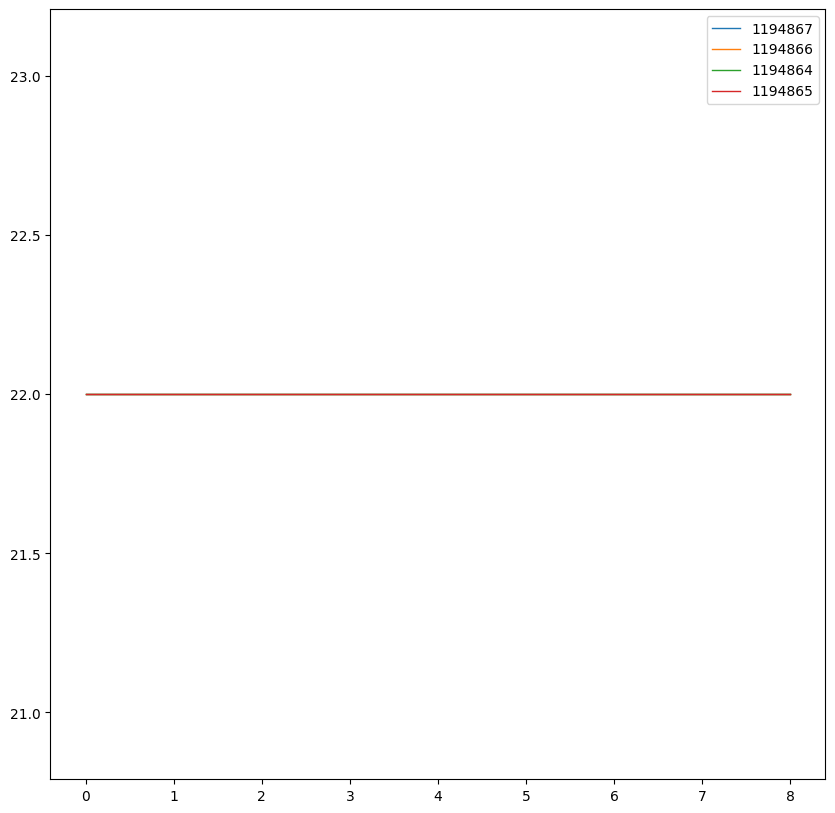

epoch_mean


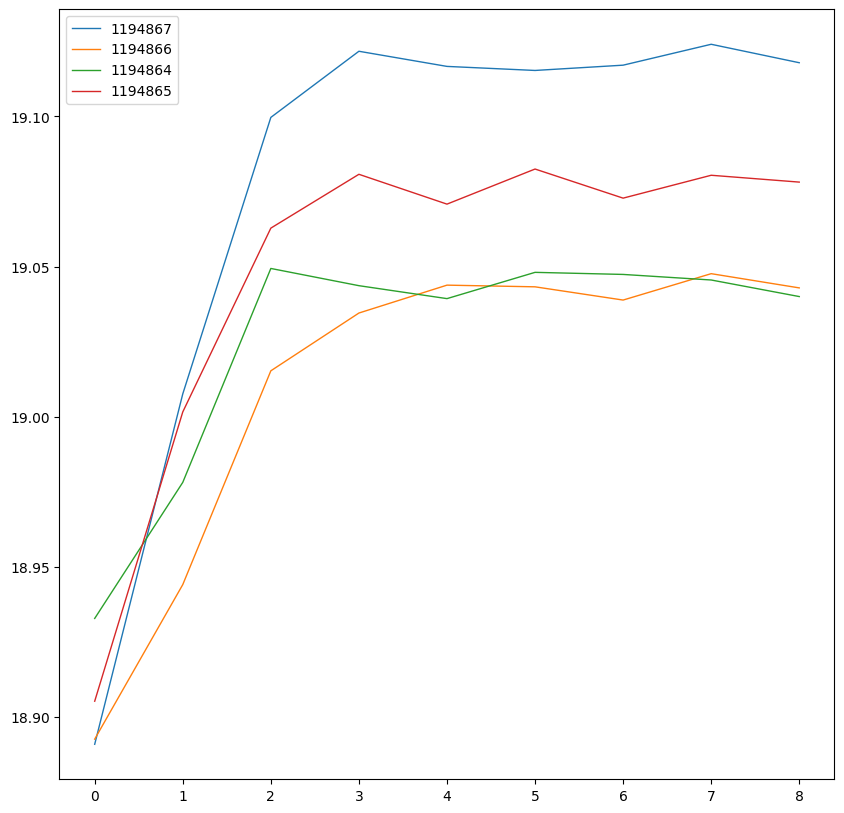

epoch_mean_train


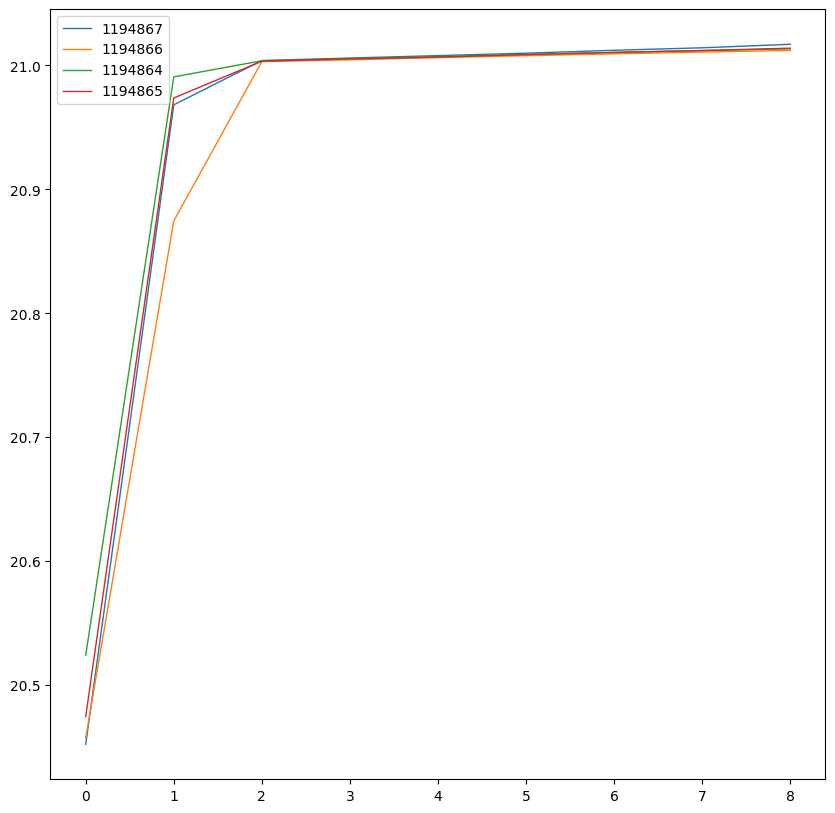

epoch_top_score_count


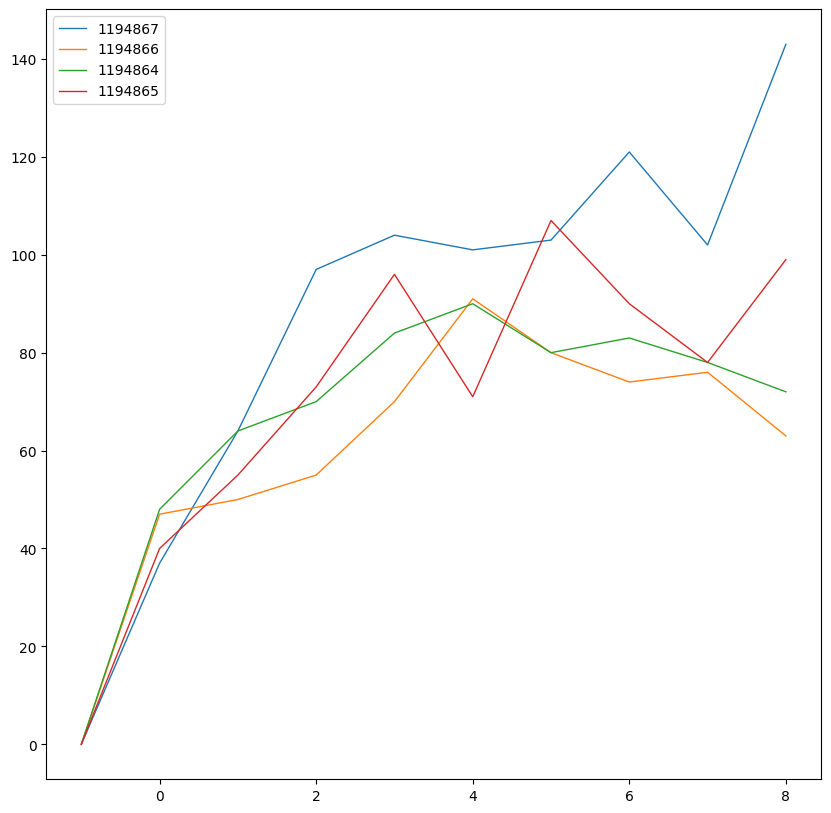

In [21]:
training_curve(data=fdata,indic="epoch_max_score",beg=0, end=-1, maxval=None,label_indic="exp_id")
training_curve(data=fdata,indic="epoch_mean",beg=0, end=-1, maxval=None,label_indic="exp_id")
training_curve(data=fdata,indic="epoch_mean_train",beg=0, end=-1, maxval=None,label_indic="exp_id")
training_curve(data=fdata,indic="epoch_top_score_count",beg=0, end=-1, maxval=None,label_indic="exp_id")
    

if has_beam:
    training_curve(fdata, "best_beam_acc")

                   
                   